In [1]:
# Cell 1: Install and import required libraries
!pip install -q xgboost

import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
import joblib
import warnings
warnings.filterwarnings("ignore")

np.random.seed(42)


In [2]:
from google.colab import files

local_path = "/content/CO2 Emissions_Canada.csv"

if not os.path.exists(local_path):
    print("Upload your CSV file")
    uploaded = files.upload()
    fname = list(uploaded.keys())[0]
    local_path = "/content/" + fname

df = pd.read_csv(local_path)
print("Loaded dataset:", df.shape)
df.head()


Loaded dataset: (7385, 12)


,Make,Model,Vehicle Class,Engine Size(L),Cylinders,Transmission,Fuel Type,Fuel Consumption City (L/100 km),Fuel Consumption Hwy (L/100 km),Fuel Consumption Comb (L/100 km),Fuel Consumption Comb (mpg),CO2 Emissions(g/km)
0,ACURA,ILX,COMPACT,2.0,4,AS5,Z,9.9,6.7,8.5,33,196
1,ACURA,ILX,COMPACT,2.4,4,M6,Z,11.2,7.7,9.6,29,221
2,ACURA,ILX HYBRID,COMPACT,1.5,4,AV7,Z,6.0,5.8,5.9,48,136
3,ACURA,MDX 4WD,SUV - SMALL,3.5,6,AS6,Z,12.7,9.1,11.1,25,255
4,ACURA,RDX AWD,SUV - SMALL,3.5,6,AS6,Z,12.1,8.7,10.6,27,244


In [3]:
# Remove high-cardinality columns
df = df.drop(columns=['Make', 'Model', 'Vehicle Class'])

# Add engineered feature
df['Efficiency'] = df['Fuel Consumption Comb (mpg)'] / df['Engine Size(L)']

# Identify target
target_col = "CO2 Emissions(g/km)"

print("Final columns:", df.columns)
df.head()


Final columns: Index(['Engine Size(L)', 'Cylinders', 'Transmission', 'Fuel Type',
       'Fuel Consumption City (L/100 km)', 'Fuel Consumption Hwy (L/100 km)',
       'Fuel Consumption Comb (L/100 km)', 'Fuel Consumption Comb (mpg)',
       'CO2 Emissions(g/km)', 'Efficiency'],
      dtype='object')


,Engine Size(L),Cylinders,Transmission,Fuel Type,Fuel Consumption City (L/100 km),Fuel Consumption Hwy (L/100 km),Fuel Consumption Comb (L/100 km),Fuel Consumption Comb (mpg),CO2 Emissions(g/km),Efficiency
0,2.0,4,AS5,Z,9.9,6.7,8.5,33,196,16.500000
1,2.4,4,M6,Z,11.2,7.7,9.6,29,221,12.083333
2,1.5,4,AV7,Z,6.0,5.8,5.9,48,136,32.000000
3,3.5,6,AS6,Z,12.7,9.1,11.1,25,255,7.142857
4,3.5,6,AS6,Z,12.1,8.7,10.6,27,244,7.714286


In [4]:
df.info()
print("\nMissing Values:\n", df.isnull().sum())
df.describe().T


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7385 entries, 0 to 7384
Data columns (total 10 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   Engine Size(L)                    7385 non-null   float64
 1   Cylinders                         7385 non-null   int64  
 2   Transmission                      7385 non-null   object 
 3   Fuel Type                         7385 non-null   object 
 4   Fuel Consumption City (L/100 km)  7385 non-null   float64
 5   Fuel Consumption Hwy (L/100 km)   7385 non-null   float64
 6   Fuel Consumption Comb (L/100 km)  7385 non-null   float64
 7   Fuel Consumption Comb (mpg)       7385 non-null   int64  
 8   CO2 Emissions(g/km)               7385 non-null   int64  
 9   Efficiency                        7385 non-null   float64
dtypes: float64(5), int64(3), object(2)
memory usage: 577.1+ KB

Missing Values:
 Engine Size(L)                      0
Cylinders        

,count,mean,std,min,25%,50%,75%,max
Engine Size(L),7385.0,3.160068,1.354170,0.900,2.000000,3.0,3.7,8.400000
Cylinders,7385.0,5.615030,1.828307,3.000,4.000000,6.0,6.0,16.000000
Fuel Consumption City (L/100 km),7385.0,12.556534,3.500274,4.200,10.100000,12.1,14.6,30.600000
Fuel Consumption Hwy (L/100 km),7385.0,9.041706,2.224456,4.000,7.500000,8.7,10.2,20.600000
Fuel Consumption Comb (L/100 km),7385.0,10.975071,2.892506,4.100,8.900000,10.6,12.6,26.100000
Fuel Consumption Comb (mpg),7385.0,27.481652,7.231879,11.000,22.000000,27.0,32.0,69.000000
CO2 Emissions(g/km),7385.0,250.584699,58.512679,96.000,208.000000,246.0,288.0,522.000000
Efficiency,7385.0,11.225689,7.111068,1.625,5.833333,9.0,15.5,46.666667


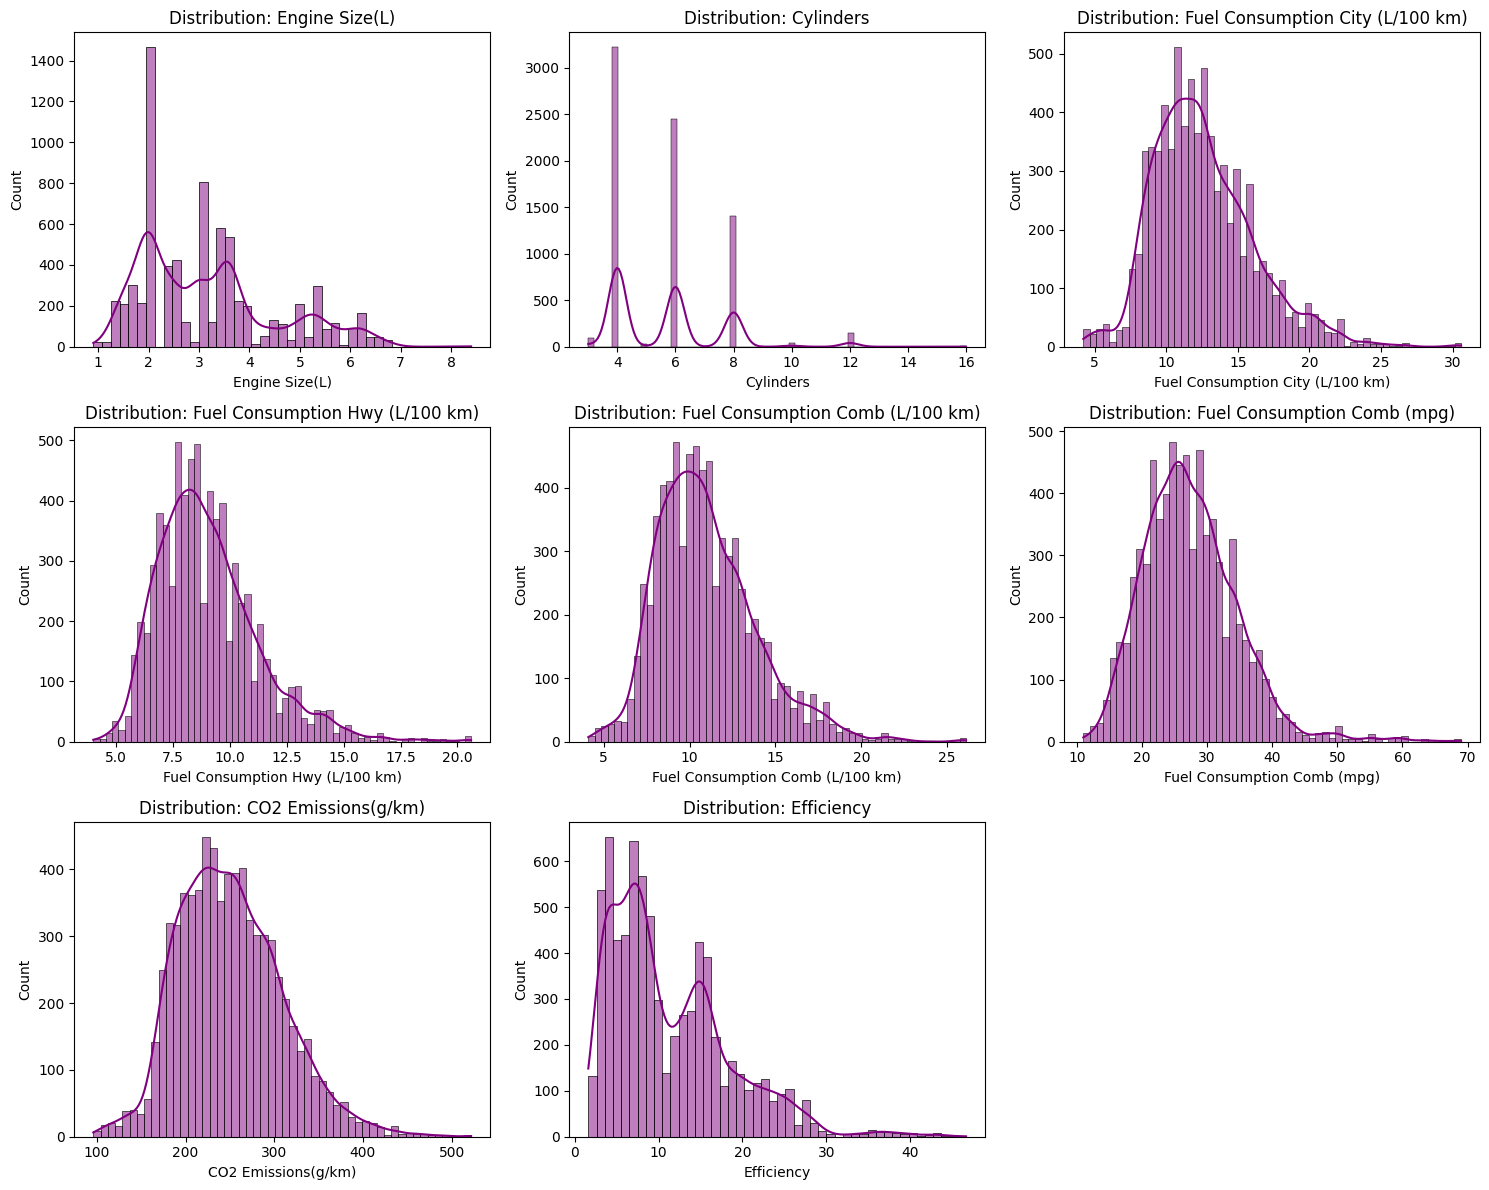

In [5]:
numeric_cols = df.select_dtypes(include=[np.number]).columns

plt.figure(figsize=(15, 12))
for i, col in enumerate(numeric_cols, 1):
    plt.subplot(3, 3, i)
    sns.histplot(df[col], kde=True, color='purple')
    plt.title(f"Distribution: {col}")
plt.tight_layout()
plt.show()


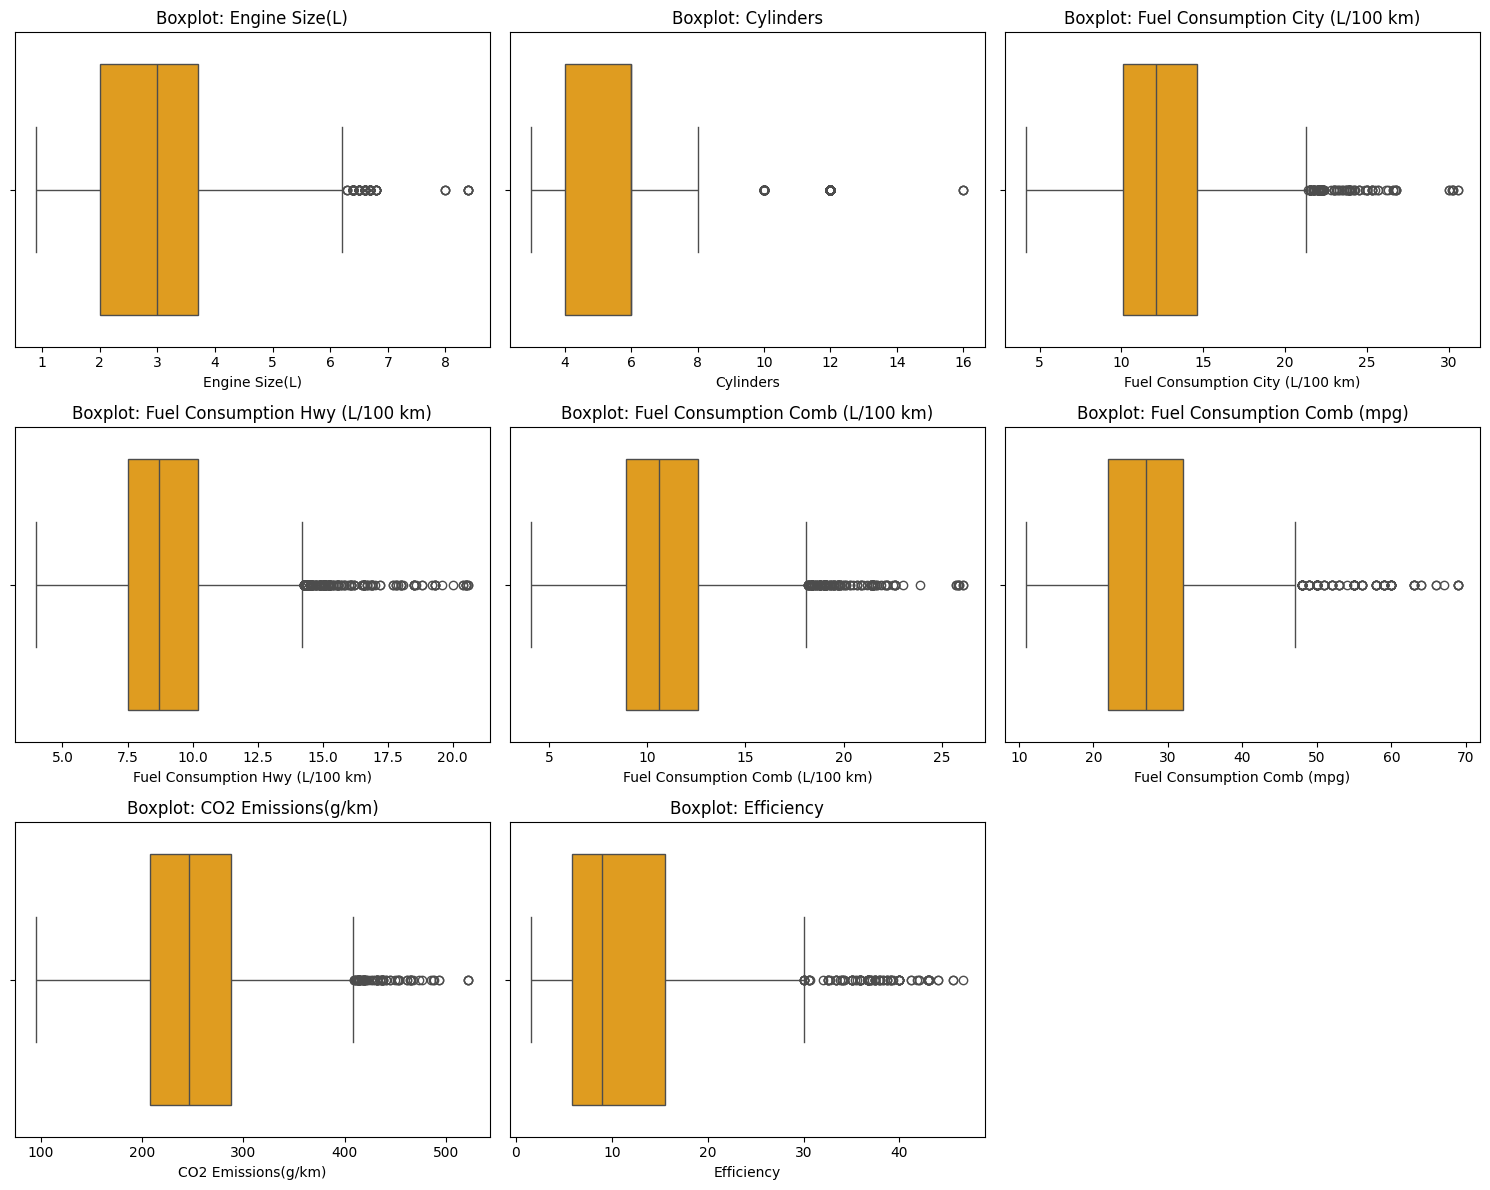

In [6]:
plt.figure(figsize=(15, 12))
for i, col in enumerate(numeric_cols, 1):
    plt.subplot(3, 3, i)
    sns.boxplot(x=df[col], color='orange')
    plt.title(f"Boxplot: {col}")
plt.tight_layout()
plt.show()


In [10]:
# Cell 7: Removing Outliers using the IQR method

clean_df = df.copy()

numeric_cols = clean_df.select_dtypes(include=[np.number]).columns

print("Numeric columns:", numeric_cols)

original_rows = clean_df.shape[0]

for col in numeric_cols:
    Q1 = clean_df[col].quantile(0.25)
    Q3 = clean_df[col].quantile(0.75)
    IQR = Q3 - Q1

    lower = Q1 - 1.5 * IQR
    upper = Q3 + 1.5 * IQR

    clean_df = clean_df[(clean_df[col] >= lower) & (clean_df[col] <= upper)]

cleaned_rows = clean_df.shape[0]

print("Rows before cleaning:", original_rows)
print("Rows after cleaning :", cleaned_rows)
print("Rows removed        :", original_rows - cleaned_rows)
print("Percentage removed  :", round((original_rows - cleaned_rows)/original_rows * 100, 2), "%")


Numeric columns: Index(['Engine Size(L)', 'Cylinders', 'Fuel Consumption City (L/100 km)',
       'Fuel Consumption Hwy (L/100 km)', 'Fuel Consumption Comb (L/100 km)',
       'Fuel Consumption Comb (mpg)', 'CO2 Emissions(g/km)', 'Efficiency'],
      dtype='object')
Rows before cleaning: 7385
Rows after cleaning : 6646
Rows removed        : 739
Percentage removed  : 10.01 %


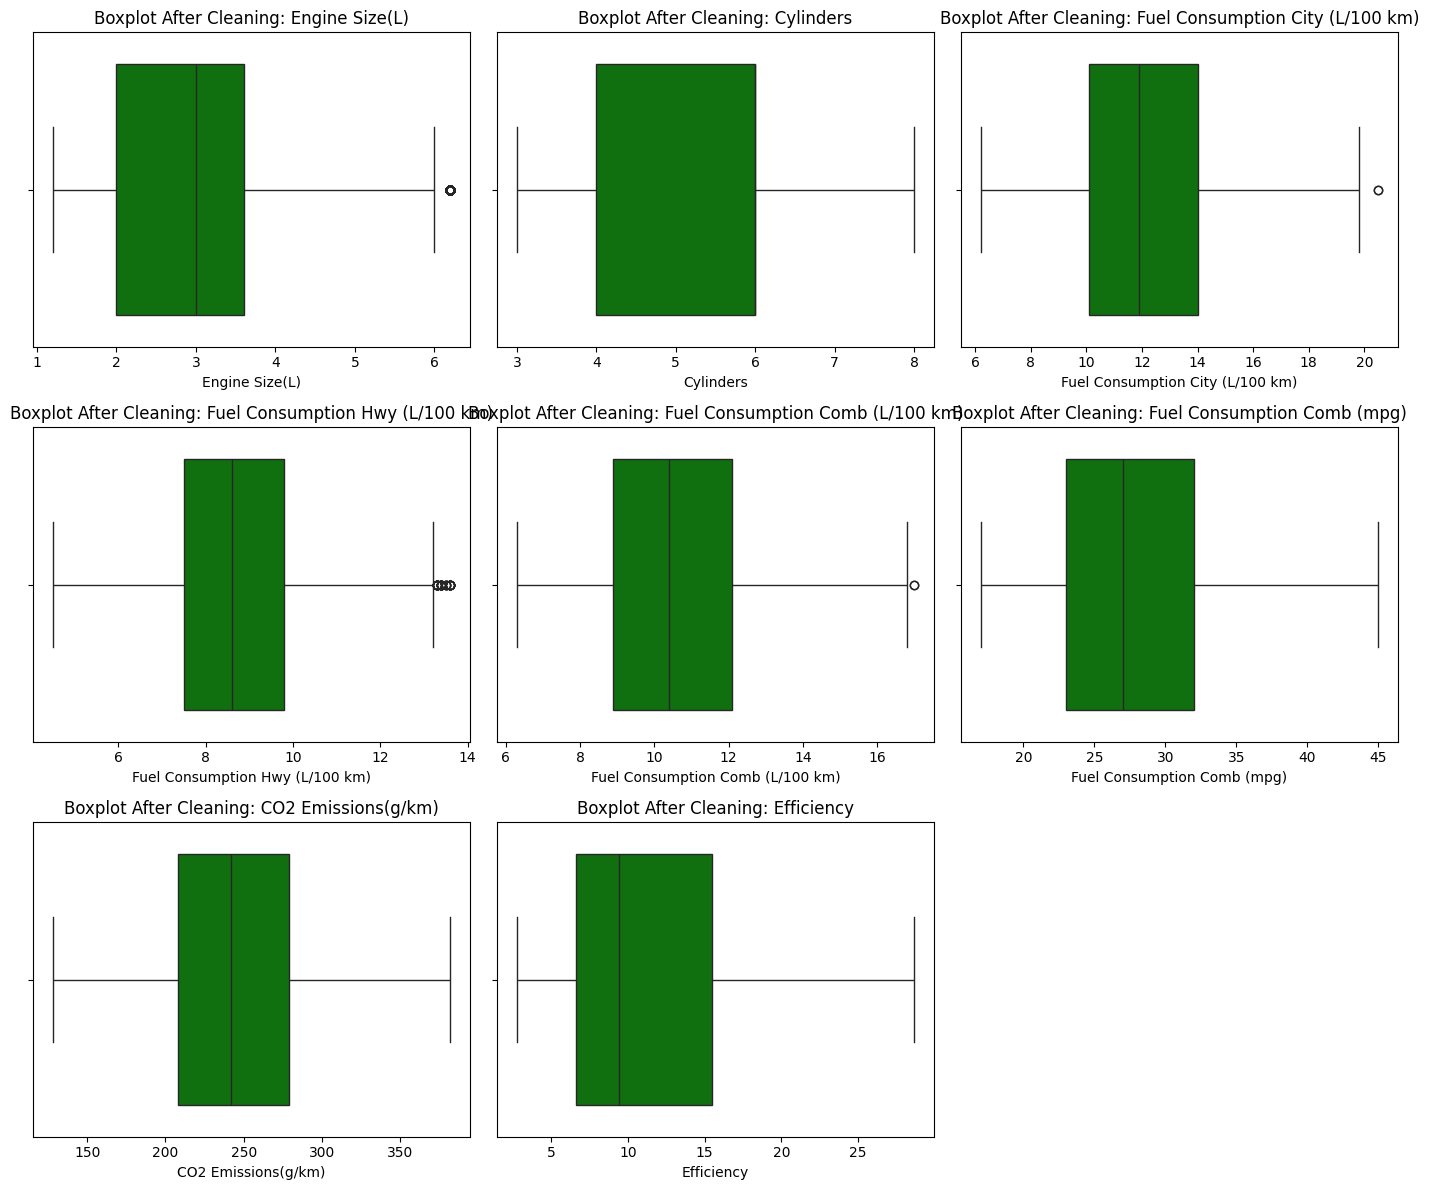

In [11]:
# Cell 8: Visualizing boxplots after outlier removal

clean_numeric = clean_df.select_dtypes(include=[np.number]).columns

plt.figure(figsize=(14, 12))
for i, col in enumerate(clean_numeric, 1):
    plt.subplot(3, 3, i)
    sns.boxplot(x=clean_df[col], color='green')
    plt.title(f"Boxplot After Cleaning: {col}")
plt.tight_layout()
plt.show()


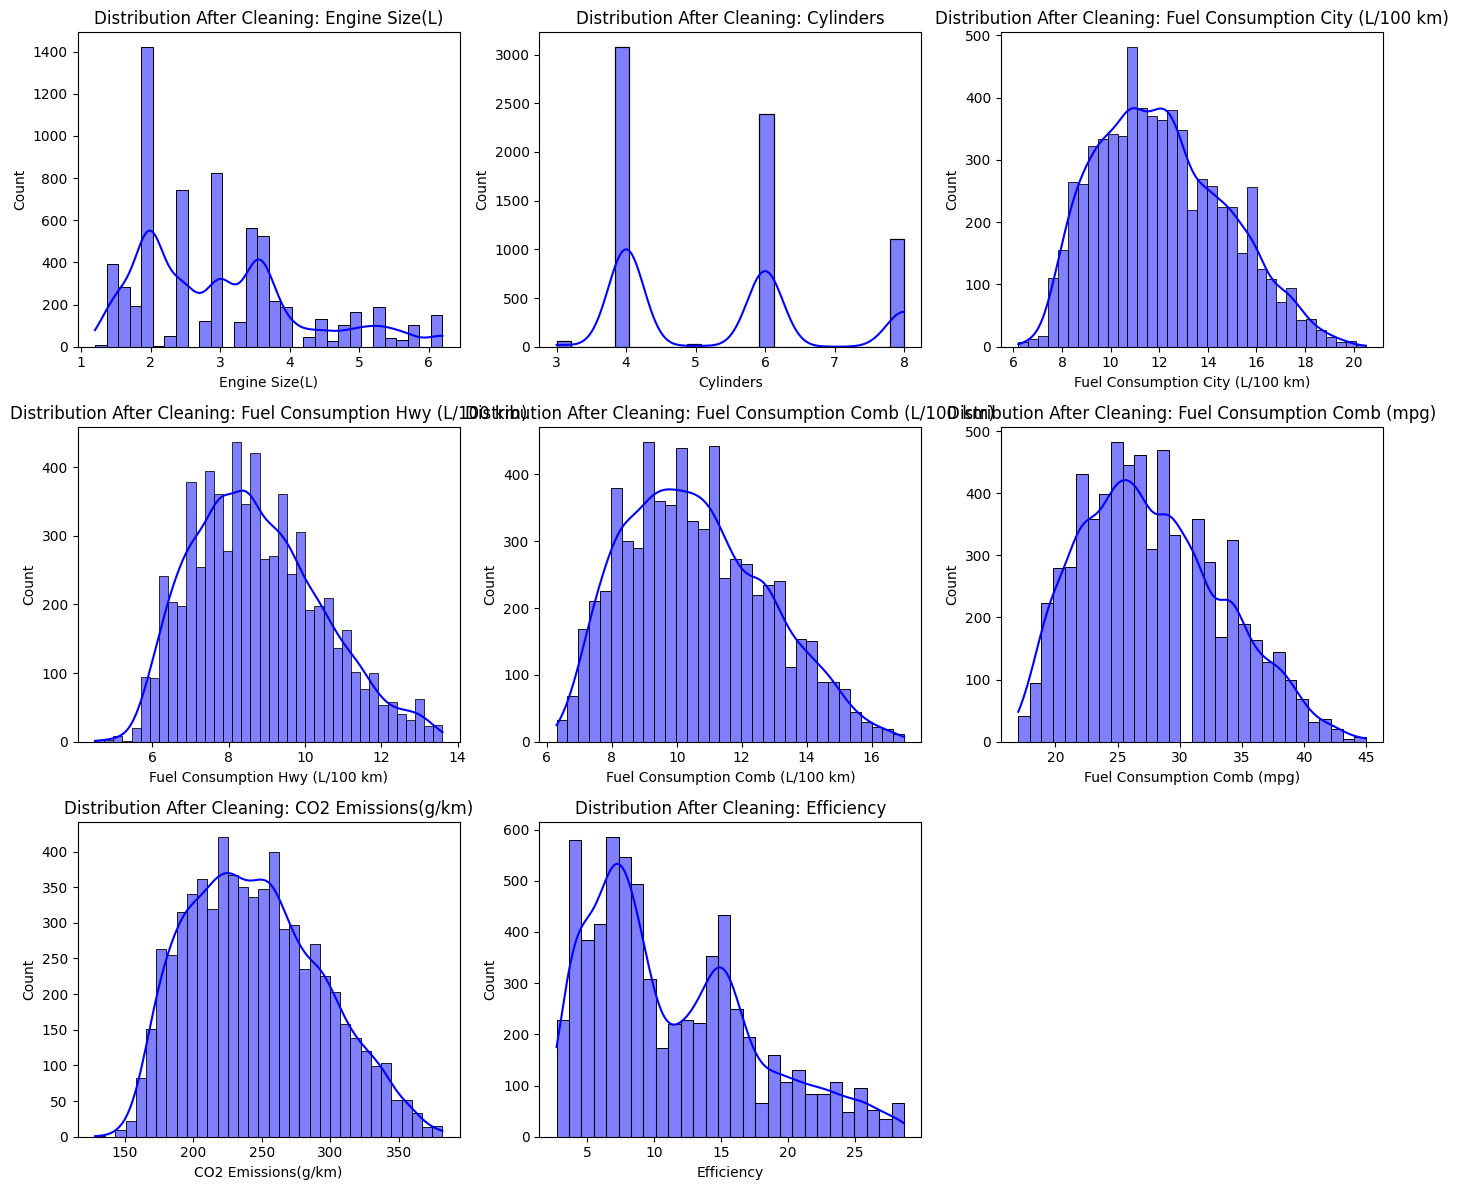

In [12]:
# Cell 9: Distribution plots after outlier removal

plt.figure(figsize=(14, 12))
for i, col in enumerate(clean_numeric, 1):
    plt.subplot(3, 3, i)
    sns.histplot(clean_df[col], kde=True, color='blue')
    plt.title(f"Distribution After Cleaning: {col}")
plt.tight_layout()
plt.show()


In [13]:
# Cell 10: Use the cleaned dataset for modeling
df = clean_df.copy()
print("Data updated for next steps. New shape:", df.shape)


Data updated for next steps. New shape: (6646, 10)


In [14]:
# Cell 11: Select features for modeling after cleaning

feature_cols = [
    'Engine Size(L)',
    'Cylinders',
    'Fuel Consumption City (L/100 km)',
    'Fuel Consumption Hwy (L/100 km)',
    'Fuel Consumption Comb (L/100 km)',
    'Fuel Type',
    'Transmission',
    'Efficiency'
]

X = df[feature_cols]
y = df['CO2 Emissions(g/km)']

print("X Shape:", X.shape)
print("y Shape:", y.shape)
X.head()


X Shape: (6646, 8)
y Shape: (6646,)


,Engine Size(L),Cylinders,Fuel Consumption City (L/100 km),Fuel Consumption Hwy (L/100 km),Fuel Consumption Comb (L/100 km),Fuel Type,Transmission,Efficiency
0,2.0,4,9.9,6.7,8.5,Z,AS5,16.500000
1,2.4,4,11.2,7.7,9.6,Z,M6,12.083333
3,3.5,6,12.7,9.1,11.1,Z,AS6,7.142857
4,3.5,6,12.1,8.7,10.6,Z,AS6,7.714286
5,3.5,6,11.9,7.7,10.0,Z,AS6,8.000000


In [15]:
# Cell 12: Preprocessing pipeline

numeric_features = X.select_dtypes(include=[np.number]).columns.tolist()
categorical_features = X.select_dtypes(include=['object']).columns.tolist()

from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer

numeric_transformer = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

preprocessor = ColumnTransformer([
    ('num', numeric_transformer, numeric_features),
    ('cat', categorical_transformer, categorical_features)
])

print("Numeric columns:", numeric_features)
print("Categorical columns:", categorical_features)


Numeric columns: ['Engine Size(L)', 'Cylinders', 'Fuel Consumption City (L/100 km)', 'Fuel Consumption Hwy (L/100 km)', 'Fuel Consumption Comb (L/100 km)', 'Efficiency']
Categorical columns: ['Fuel Type', 'Transmission']


In [16]:
# Cell 13: Split into training and testing set

from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

print("Training shape:", X_train.shape)
print("Testing shape :", X_test.shape)


Training shape: (5316, 8)
Testing shape : (1330, 8)


In [18]:
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor

models = {
    "Linear Regression": Pipeline(
        [('pre', preprocessor), ('model', LinearRegression())]
    ),

    "Random Forest": Pipeline(
        [('pre', preprocessor), ('model', RandomForestRegressor(n_estimators=250, random_state=42))]
    ),

    "XGBoost": Pipeline(
        [('pre', preprocessor), ('model', XGBRegressor(
            n_estimators=300,
            learning_rate=0.1,
            max_depth=6,
            subsample=0.9,
            colsample_bytree=0.9,
            random_state=42))
    ])
}

results = {}

for name, model in models.items():
    model.fit(X_train, y_train)
    preds = model.predict(X_test)
    mse = mean_squared_error(y_test, preds)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_test, preds)
    results[name] = (rmse, r2)

    print(f"{name}: RMSE = {rmse:.3f}, R² = {r2:.3f}")

Linear Regression: RMSE = 3.729, R² = 0.994
Random Forest: RMSE = 3.438, R² = 0.995
XGBoost: RMSE = 3.512, R² = 0.995


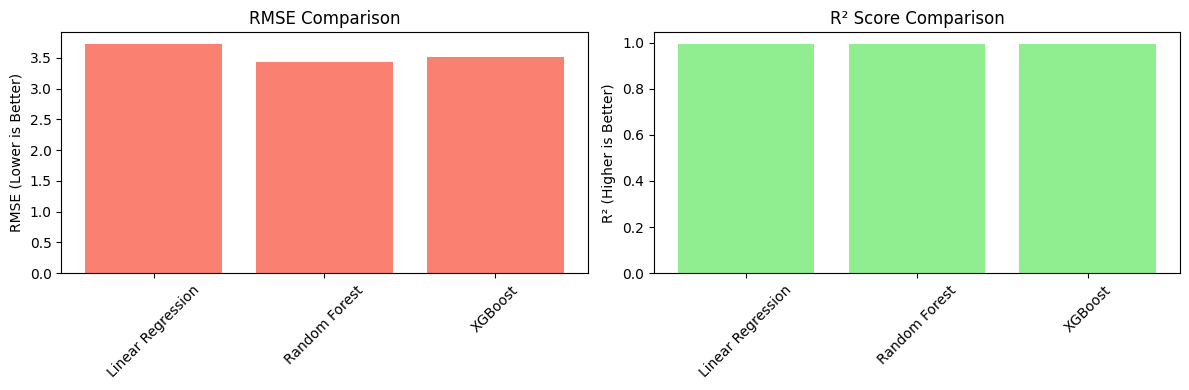

In [19]:
# Cell 15: Model comparison bar graph

names = list(results.keys())
rmse_vals = [results[m][0] for m in names]
r2_vals = [results[m][1] for m in names]

plt.figure(figsize=(12, 4))

# RMSE chart
plt.subplot(1, 2, 1)
plt.bar(names, rmse_vals, color='salmon')
plt.title("RMSE Comparison")
plt.xticks(rotation=45)
plt.ylabel("RMSE (Lower is Better)")

# R2 chart
plt.subplot(1, 2, 2)
plt.bar(names, r2_vals, color='lightgreen')
plt.title("R² Score Comparison")
plt.xticks(rotation=45)
plt.ylabel("R² (Higher is Better)")

plt.tight_layout()
plt.show()


Best Model = Random Forest


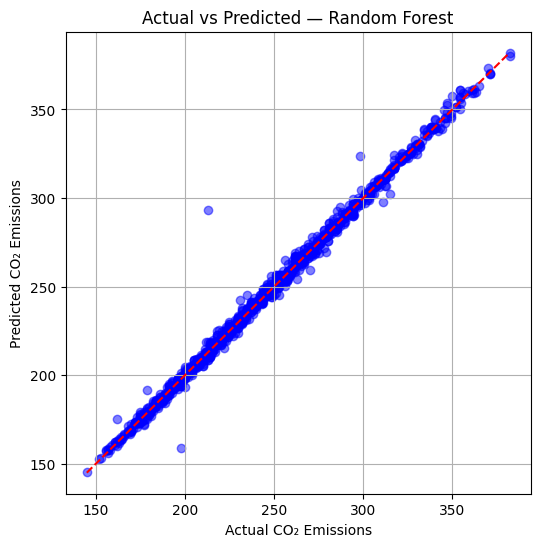

In [20]:
# Cell 16: Actual vs Predicted Visualization

best_name = min(results, key=lambda x: results[x][0])
best_model = models[best_name]

print("Best Model =", best_name)

preds = best_model.predict(X_test)

plt.figure(figsize=(6, 6))
plt.scatter(y_test, preds, alpha=0.5, color='blue')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.xlabel("Actual CO₂ Emissions")
plt.ylabel("Predicted CO₂ Emissions")
plt.title(f"Actual vs Predicted — {best_name}")
plt.grid()
plt.show()


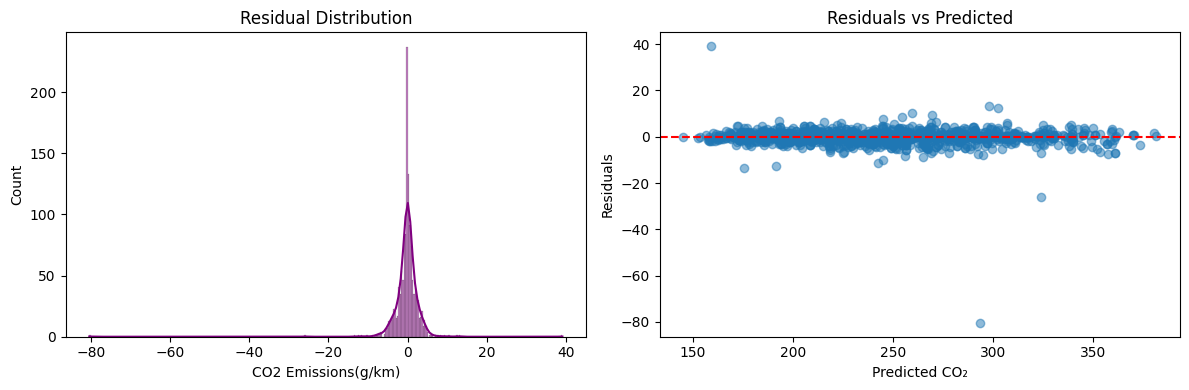

In [21]:
# Cell 17: Residual analysis

residuals = y_test - preds

plt.figure(figsize=(12, 4))

# Residual distribution
plt.subplot(1, 2, 1)
sns.histplot(residuals, kde=True, color='purple')
plt.title("Residual Distribution")

# Residual vs predicted
plt.subplot(1, 2, 2)
plt.scatter(preds, residuals, alpha=0.5)
plt.axhline(0, linestyle='--', color='red')
plt.title("Residuals vs Predicted")
plt.xlabel("Predicted CO₂")
plt.ylabel("Residuals")

plt.tight_layout()
plt.show()


In [22]:
# Detect and remove extreme residuals

error_df = pd.DataFrame({
    'Actual': y_test,
    'Predicted': preds,
    'Residual': residuals
})

# Define upper bound for residuals (3 std deviations)
threshold = 3 * error_df['Residual'].std()

clean_error_df = error_df[abs(error_df['Residual']) < threshold]

print("Original test size:", len(error_df))
print("Cleaned test size :", len(clean_error_df))
print("Removed           :", len(error_df) - len(clean_error_df))


Original test size: 1330
Cleaned test size : 1321
Removed           : 9


In [23]:
# Cell 18: Remove original rows causing extreme residuals

# Identify indices of clean predictions
clean_indices = clean_error_df.index

# Convert X_test and y_test to DataFrame for index alignment
X_test_df = X_test.copy()
y_test_df = y_test.copy()

# Keep only rows corresponding to clean residuals
X_test_clean = X_test_df.loc[clean_indices]
y_test_clean = y_test_df.loc[clean_indices]

print("Clean test data shape:", X_test_clean.shape, y_test_clean.shape)


Clean test data shape: (1321, 8) (1321,)


In [25]:
# Cell 19: Retrain model on training data (unchanged)
# Then evaluate on cleaned test data

best_name = min(results, key=lambda x: results[x][0])
best_model = models[best_name]

best_model.fit(X_train, y_train)

clean_preds = best_model.predict(X_test_clean)

clean_mse = mean_squared_error(y_test_clean, clean_preds)
clean_rmse = np.sqrt(clean_mse)
clean_r2 = r2_score(y_test_clean, clean_preds)

print("Before Cleaning → RMSE:", results[best_name][0], "  R²:", results[best_name][1])
print("After Cleaning  → RMSE:", clean_rmse, "  R²:", clean_r2)

Before Cleaning → RMSE: 3.437644956028868   R²: 0.9947825291146112
After Cleaning  → RMSE: 2.1523633943613065   R²: 0.9979498674667555


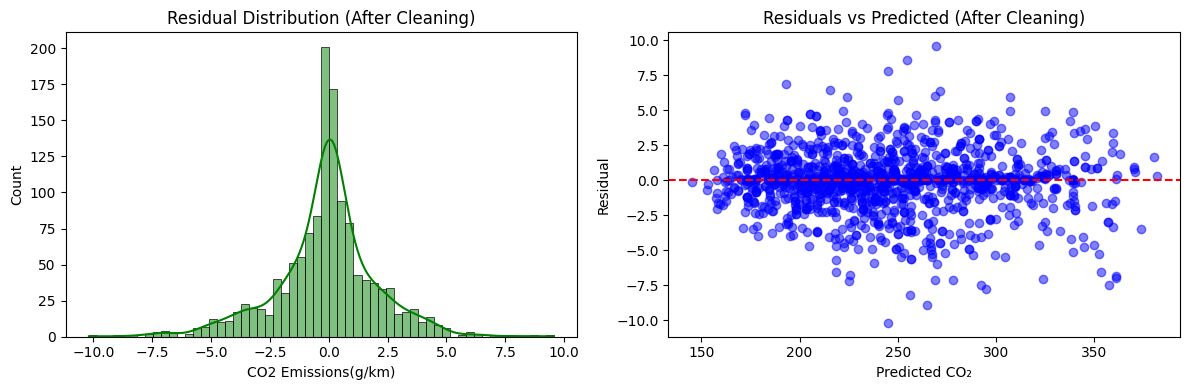

In [26]:
# Cell 20: Plot improved residuals

clean_residuals = y_test_clean - clean_preds

plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
sns.histplot(clean_residuals, kde=True, color='green')
plt.title("Residual Distribution (After Cleaning)")

plt.subplot(1, 2, 2)
plt.scatter(clean_preds, clean_residuals, alpha=0.5, color='blue')
plt.axhline(0, linestyle='--', color='red')
plt.title("Residuals vs Predicted (After Cleaning)")
plt.xlabel("Predicted CO₂")
plt.ylabel("Residual")

plt.tight_layout()
plt.show()


In [28]:
# Retrain full model on the cleaned dataset (df)

X = df[feature_cols]
y = df['CO2 Emissions(g/km)']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

final_models = {
    "Linear Regression": Pipeline([
        ('pre', preprocessor),
        ('model', LinearRegression())
    ]),

    "Random Forest": Pipeline([
        ('pre', preprocessor),
        ('model', RandomForestRegressor(n_estimators=250, random_state=42))
    ]),

    "XGBoost": Pipeline([
        ('pre', preprocessor),
        ('model', XGBRegressor(
            n_estimators=300,
            learning_rate=0.1,
            max_depth=6,
            subsample=0.9,
            colsample_bytree=0.9,
            random_state=42))
    ])
}

final_results = {}

for name, model in final_models.items():
    model.fit(X_train, y_train)
    preds = model.predict(X_test)
    mse = mean_squared_error(y_test, preds)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_test, preds)
    final_results[name] = (rmse, r2)
    print(f"{name}: RMSE={rmse:.2f}, R²={r2:.3f}")

Linear Regression: RMSE=3.73, R²=0.994
Random Forest: RMSE=3.44, R²=0.995
XGBoost: RMSE=3.51, R²=0.995


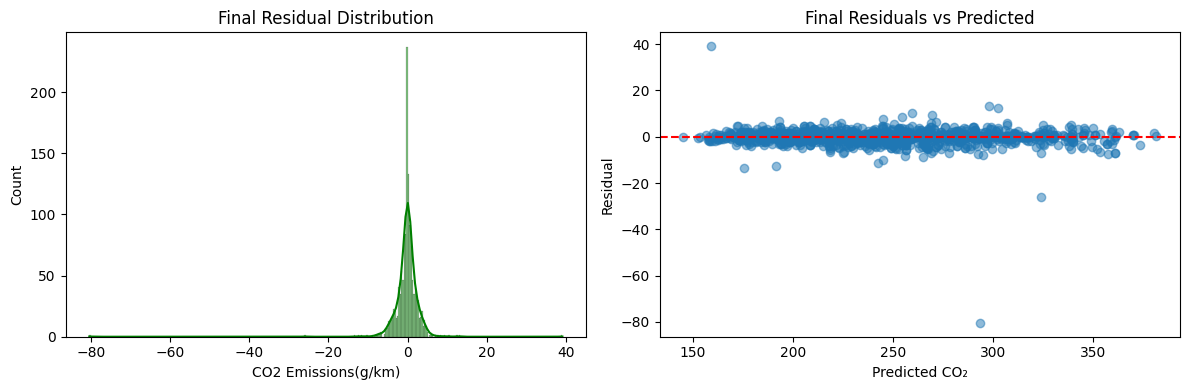

In [29]:
best_name = min(final_results, key=lambda x: final_results[x][0])
best_model = final_models[best_name]

final_preds = best_model.predict(X_test)
final_residuals = y_test - final_preds

plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
sns.histplot(final_residuals, kde=True, color='green')
plt.title("Final Residual Distribution")

plt.subplot(1, 2, 2)
plt.scatter(final_preds, final_residuals, alpha=0.5)
plt.axhline(0, linestyle='--', color='red')
plt.title("Final Residuals vs Predicted")
plt.xlabel("Predicted CO₂")
plt.ylabel("Residual")

plt.tight_layout()
plt.show()


In [30]:
joblib.dump(best_model, "final_CO2_model.joblib")
print("Saved final model:", best_name)


Saved final model: Random Forest
